# Demo of function easy\_map from *./swiss_utils/sdc_utilities.py*

*****

** This script is the "official demo" of a function. Please if you want to modify it, work on your own copy. **

Plotting map from xarray is not straight forward as the function to use vary depending on the ty of array to plot. Moreover some function plot square shape without keeping the same resolution on x and y. The easy_map function try to facilitate this issues.

In [1]:
# Import necessary stuff
%matplotlib inline

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

from utils.dc_display_map import display_map
from utils.dc_utilities import perform_timeseries_analysis

import datacube
dc = datacube.Datacube()
api = datacube.api.API()

# IMPORT EASY_EXPORT FUNCTION
from swiss_utils.sdc_utilities import easy_map

In [2]:
# Define mini DC parameters landscape mode
platform ="LANDSAT_8"
product = "ls8_ledaps_swiss"

min_lon = 7.05
max_lon = 7.15
min_lat = 46.6
max_lat = 46.73

start_date = datetime.strptime("2015-1-1", '%Y-%m-%d')
end_date = datetime.strptime("2015-2-28", '%Y-%m-%d')
title = "Water"
monit_cats = [1]
no_cats = [2,4,255]

In [3]:
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

# NDVI

In [4]:
# Get a mini DC
dataset_in = dc.load(platform=platform,
                     product=product,
                     time=(start_date, end_date),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['red','nir'])
#print(dataset_in)

In [5]:
# To get rid of division per zero warning
import warnings; warnings.simplefilter('ignore')

ndvi = (dataset_in.nir - dataset_in.red) / (dataset_in.nir + dataset_in.red)
#print(ndvi)

Map the time 1 of NDVI xarray.Dataset using custom colormap and a maximum size of 16.

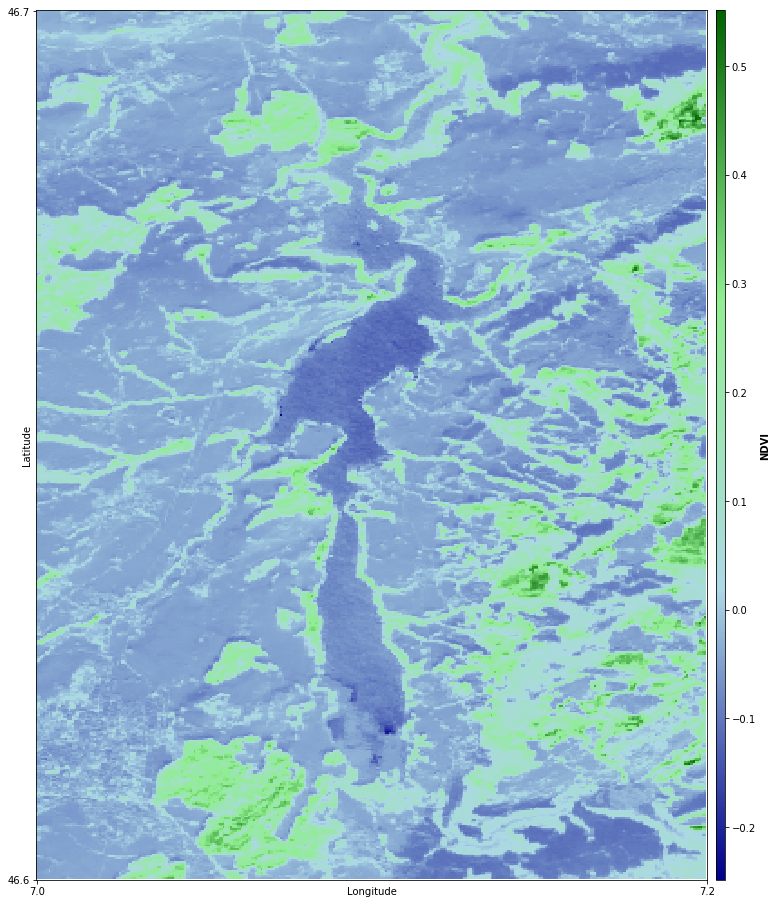

In [6]:
easy_map(ndvi.isel(time=1),
         colors.LinearSegmentedColormap.from_list('ndvi', ['darkblue','lightblue','lightgreen','darkgreen'], N=256),
         'NDVI', 16)

# Water monitoring

In [7]:
# Workaround as xa.apply_ufunc is not implemented in this version (0.9.6) of xarray

def tupple_to_cond(cats):
    for m in range(1,len(cats)+1):
        if m == 1: cond_cats = '(dataset_in.cf_mask == %i)' % (cats[m-1])
        else: cond_cats = '%s | (dataset_in.cf_mask == %i)' % (cond_cats, cats[m-1])
    return cond_cats

In [8]:
# Get a Mini Data Cube
dataset_in = dc.load(platform=platform,
                     product=product,
                     time=(start_date, end_date),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['cf_mask'])
#print(dataset_in)

In [9]:
# Reclassify the MDC
mcat = eval(tupple_to_cond(monit_cats))
mcat_dataset = mcat.astype(np.uint8).to_dataset(name = "mcat")
# Define no data categories and apply them on MDC
if len(no_cats) > 0:
    no_data = eval(tupple_to_cond(no_cats))
    no_data = no_data.values
    # Apply no_data on MDC
    mcat_dataset.mcat.values[no_data] = 255
#print(mcat_dataset)

In [10]:
import warnings; warnings.simplefilter('ignore')

# Perform time series analysis
ts = perform_timeseries_analysis(mcat_dataset, "mcat", no_data = 255)

Map normalized variable of ts xarray. Dataset using standard GnBu colormap and a maximum size of 3.

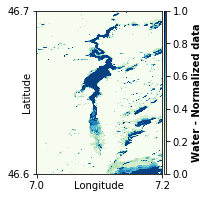

In [11]:
# Here come the function ...
easy_map(ts.normalized_data, 'GnBu', 'Water - Normalized data', 3)

Same map using a custom colormap and the default maximum size.

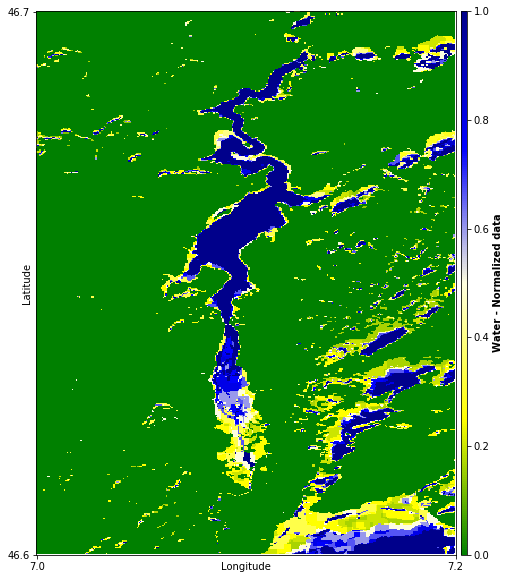

In [12]:
# ... and again ...
easy_map(ts.normalized_data,
            colors.LinearSegmentedColormap.from_list('water', ['green','yellow','lightyellow','blue','darkblue'], N=256),
            'Water - Normalized data')

# MS bands

This time let's define an AOI with landscape orientation

In [13]:
# Get a mini DC
# New landscape orientation
min_lon = 7.25
max_lon = 7.40
min_lat = 46.95
max_lat = 46.98

dataset_in = dc.load(platform=platform,
                     product=product,
                     time=(start_date, end_date),
                     lon=(min_lon, max_lon), 
                     lat=(min_lat, max_lat),
                     measurements=['red','green','blue'])
#print(dataset_in)

In [14]:
display_map(latitude = (min_lat, max_lat), longitude = (min_lon, max_lon))

Map time 0 blue variable of dataset_in xarray.Dataset using standard Greys colormap, but inversed (_r) and a maximum size of 16.

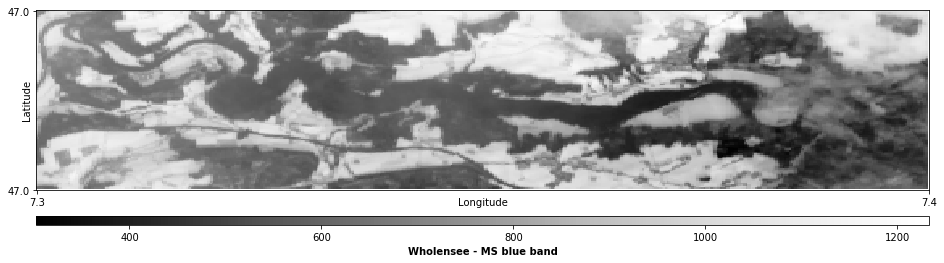

In [15]:
# ... and again ...
easy_map(dataset_in.isel(time=0).blue, 'Greys_r','Wholensee - MS blue band',16)

** To plot multiple bands composite do as follows. **

But you need to know the range of values of each band to set up properly the scale parameter.

In [16]:
from utils.dc_utilities import write_png_from_xr
write_png_from_xr('ms_rgb.png', dataset_in.isel(time = 0), ["red", "green", "blue"], scale = [(0,2000),(0,2000),(0,2000)])

![](ms_rgb.png)

Improve the readibility of your composite by saturating 2.5% extrem values.

(I wish I have time to write a script to to it automatically.)

In [17]:
print(dataset_in.isel(time = 0).red.quantile([0.025,0.975]))
print(dataset_in.isel(time = 0).green.quantile([0.025,0.975]))
print(dataset_in.isel(time = 0).blue.quantile([0.025,0.975]))

<xarray.DataArray 'red' (quantile: 2)>
array([  369.,  1156.])
Coordinates:
  * quantile  (quantile) float64 0.025 0.975
<xarray.DataArray 'green' (quantile: 2)>
array([  403.,  1168.])
Coordinates:
  * quantile  (quantile) float64 0.025 0.975
<xarray.DataArray 'blue' (quantile: 2)>
array([  422.,  1123.])
Coordinates:
  * quantile  (quantile) float64 0.025 0.975


In [18]:
write_png_from_xr('ms_rgb_95.png', dataset_in.isel(time = 0), ["red", "green", "blue"], scale = [(369,1156),(403,1168),(422,1123)])

![](ms_rgb_95.png)